In [1]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
from pyscf.scf.hf import dump_scf_summary
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


/Users/ksu/Documents/GitHub/pyqmc2/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [2]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 20", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

# for fname in ['scf.hdf5','ci.hdf5']:
#     if os.path.isfile(fname):
#         os.remove(fname)

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_li(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

Li atom neutral LDA spin=1
HF
converged SCF energy = -7.43270205121318  <S^2> = 0.75001434  2S+1 = 2.0000143
LDA
converged SCF energy = -7.34320268053483  <S^2> = 0.75000173  2S+1 = 2.0000017


In [3]:
tstep = 0.001
nconfig = 200
nsteps = 1000
discard = 1500

In [5]:
import pyqmc
for fname in ['vmc_test.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
pyqmc.recipes.VMC("scf.hdf5", "vmc_test.hdf5",  verbose=True, nsteps=int(nsteps*2), tstep=tstep*1, nconfig=nconfig)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Mean  etot ,  -1.0736555360852826 +/- 0.0003345513847894254
Mean  ee ,  0.571449643859268 +/- 0.0003284346284360926
Mean  ei ,  -3.1360058226153216 +/- 0.004292424439499557
Mean  ke ,  0.9909006426707709 +/- 0.005817439711168765


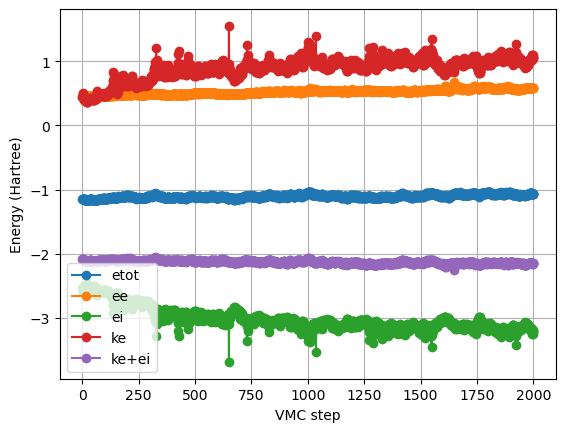

In [6]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

import matplotlib.pyplot as plt
with h5py.File("vmc_test.hdf5") as f:
    ee = f['energyee'][...]   
    ei = f['energyei'][...]
    # ii = f['energyii'][...]    
    ke = f['energyke'][...]
    etot = f['energytotal'][...]
# plt.plot(e_est, marker='o', label="E_est")
# plt.plot(e_t, marker='o', label="E_t")
plt.plot(etot, marker='o', label="etot")
plt.plot(ee, marker='o', label="ee")
plt.plot(ei, marker='o', label="ei")
plt.plot(ke, marker='o', label="ke")
plt.plot(ke+ei, marker='o', label="ke+ei")
# plt.plot(ka-ka[0], marker='o', label="ka")
# plt.plot(kb-kb[0], marker='o', label="kb")

# plt.plot(vxc-vxc[0], marker='o', label="vxc")
plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
# plt.xlim((200,500))
# plt.ylim((-10, 5))
plt.grid()
# plt.figure()
for e in [etot, ee, ei, ke]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    print("Mean ", namestr(e, globals())[0], ", ", e_m, "+/-", e_d)

# e_m = np.mean(etot[discard:])
# e_d = np.var(etot[discard:])
# # e_m2 = np.mean(etot2[discard:])
# # e_d2 = np.var(etot2[discard:])
# print("Mean VMC Energy, ", e_m, "+/-", e_d)
# print("LDA Energy, ", mf.energy_tot())
# plt.plot(ed, marker='o', label="ke")

# print('ee', np.mean(ee[discard:]))
# print('ei', np.mean(ei[discard:]))
# print('ke', np.mean(ke[discard:]))


In [100]:
#ABVMC
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['abvmc-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC

# ABVMC("scf.hdf5", "abvmc-001.hdf5", verbose=True, nsteps=int(nsteps/10), tstep=int(tstep*10), nconfig=nconfig)
# ABVMC("scf.hdf5", "abvmc-001.hdf5", verbose=True, nsteps=int(nsteps/5), tstep=int(tstep*5), nconfig=nconfig)
# ABVMC("scf.hdf5", "abvmc-001.hdf5", verbose=True, nsteps=int(nsteps/2), tstep=int(tstep*2), nconfig=nconfig)
ABVMC("scf.hdf5", "abvmc-001.hdf5", verbose=True, nsteps=int(nsteps*2), tstep=tstep, nconfig=nconfig)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Mean  etot ,  -7.304125559564793 +/- 0.340588451236224
Mean  etot_abvmc ,  -7.446856434182577 +/- 0.004433967683364739
Mean  ee_abvmc ,  2.3352986957809545 +/- 0.0051981732059124515
Mean  vh_abvmc ,  8.09736008323424 +/- 0.001403682974672729
Mean  vxc_abvmc ,  -2.1676030170075986 +/- 0.00036054489666573577
Mean  ecorr_abvmc ,  -3.8523980637368926 +/- 0.0
Mean  ei_abvmc ,  -16.305712050472508 +/- 0.3702323340029121
Mean  vhxc_abvmc ,  5.929757066226641 +/- 0.000375278021950378
Mean  ii_abvmc ,  0.0 +/- 0.0
LDA Energy,  -7.3432026805348265


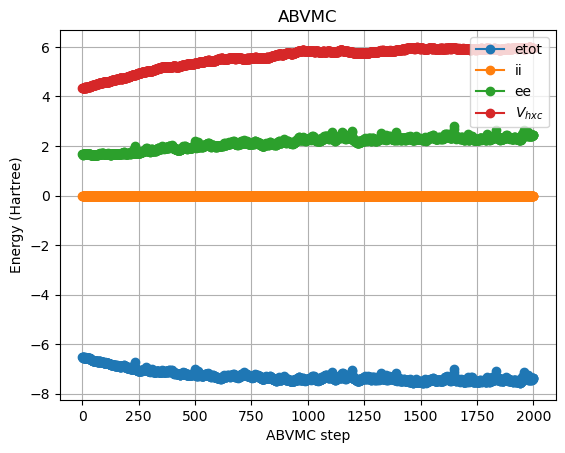

In [101]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("abvmc-001.hdf5") as f:
    ee_abvmc = f['energyee'][...]   
    ei_abvmc = f['energyei'][...]
    vh_abvmc = f['energyvh'][...]   
    vxc_abvmc = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abvmc = f['energyii'][...]    
    ke_abvmc = f['energyke'][...]
    ka_abvmc = f['energyka'][...]
    kb_abvmc = f['energykb'][...]   
    ecorr_abvmc = f['energycorr'][...]    
    etot_abvmc = f['energytotal'][...] 
vhxc_abvmc = vh_abvmc + vxc_abvmc
# plt.plot(e_t, marker='o', label="E_t")
plt.plot(etot_abvmc, marker='o', label="etot")
plt.plot(ii_abvmc, marker='o', label="ii")
plt.plot(ee_abvmc, marker='o', label="ee")
# plt.plot(ecorr_abvmc, marker='o', label="dft_eig")
# plt.plot(vxc_abvmc, marker='o', label=r"$V_{xc}$")
# plt.plot(vh_abvmc, marker='o', label=r"$V_{h}$")
plt.plot(vxc_abvmc+vh_abvmc, marker='o', label=r"$V_{hxc}$")
# plt.plot(ecorr_abvmc, marker='o', label=r"$ecorr$")


# plt.plot(ke, marker='o', label="ke")

# plt.plot(ee-eed, marker='o', label="ee-diff")
# plt.plot(ei, marker='o', label="ei")
# plt.plot(eid, marker='o', label="eid")
# plt.plot(eed, marker='o', label="eed")
# plt.plot(ei-eid, marker='o', label="ei-eid")

# eboson=ee-vxc
# plt.plot(eboson, marker='o', label="boson")
# plt.plot(ke, marker='o', label="ke")
# plt.plot(ka-ka[0], marker='o', label="ka")
# plt.plot(kb-kb[0], marker='o', label="kb")

# plt.plot(vxc-vxc[0], marker='o', label="vxc")
plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABVMC')
for e in [etot, etot_abvmc, ee_abvmc, vh_abvmc, vxc_abvmc, ecorr_abvmc, ei_abvmc, vhxc_abvmc, ii_abvmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)
# e_m2 = np.mean(etot2[discard:])
# e_d2 = np.var(etot2[discard:])

# print("Mean VMC Energy, ", df.iloc[1].energy, "+/-", df.iloc[1].error)
print("LDA Energy, ", mf_lda.energy_tot())
# plt.plot(ed, marker='o', label="ke")



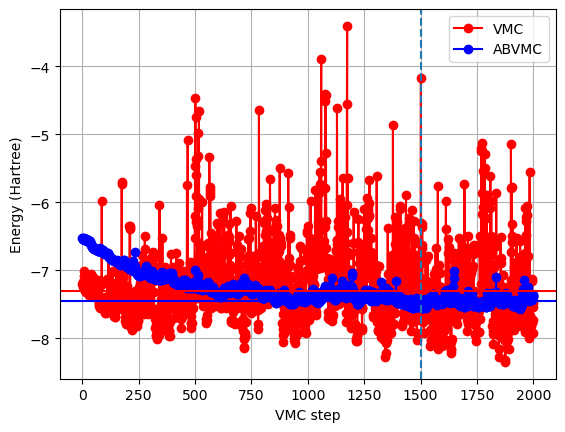

In [102]:
plt.plot(etot, marker='o', color = 'r', label="VMC")
# plt.plot(etot_j, marker='o', color = 'k', label="VMC-Jastrow")
plt.plot(etot_abvmc, marker='o', color='b', label="ABVMC")

plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
# plt.ylim((-1.4, -1))
plt.axvline(discard, linestyle='dashed')
plt.axhline(np.mean(etot[discard:]), color='r')
# plt.axhline(np.mean(etot_j[discard:]), color='k')
plt.axhline(np.mean(etot_abvmc[discard:]), color='b')
plt.grid()
